In [1]:
# =============================================================================
#
# Pronostico usando un MLP
#
# =============================================================================
import warnings

warnings.filterwarnings("ignore")

#
# Carga de datos
#
import nbimporter  #  type: ignore
import functions  #  type: ignore


df_orig = functions.load_data()
df_orig.head()

,yt_true
date,
1946-01-01,890
1946-02-01,992
1946-03-01,979
1946-04-01,959
1946-05-01,1110


In [2]:
#
# Construcción de la matriz de regresores
#
df_orig = functions.make_lagged_ts(
    df=df_orig,
    p_max=13,
    y_column="yt_true",
    fmt="lagged_{}m",
)
df_orig.head()

,yt_true,lagged_1m,lagged_2m,lagged_3m,lagged_4m,lagged_5m,lagged_6m,lagged_7m,lagged_8m,lagged_9m,lagged_10m,lagged_11m,lagged_12m,lagged_13m
date,,,,,,,,,,,,,,
1946-01-01,890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-02-01,992,890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-03-01,979,992.0,890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-04-01,959,979.0,992.0,890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1946-05-01,1110,959.0,979.0,992.0,890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#
# Remoción de los valores faltantes
#
df_dropna = df_orig.dropna()
df_dropna.head()

,yt_true,lagged_1m,lagged_2m,lagged_3m,lagged_4m,lagged_5m,lagged_6m,lagged_7m,lagged_8m,lagged_9m,lagged_10m,lagged_11m,lagged_12m,lagged_13m
date,,,,,,,,,,,,,,
1947-02-01,1517,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,959.0,979.0,992.0,890.0
1947-03-01,1707,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,959.0,979.0,992.0
1947-04-01,1729,1707.0,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,959.0,979.0
1947-05-01,1788,1729.0,1707.0,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,959.0
1947-06-01,2008,1788.0,1729.0,1707.0,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0


In [4]:
#
# División de los datos en entrenamiento y prueba
#
(
    X_complete,
    y_complete,
    X_train,
    y_train,
    X_test,
    y_test,
) = functions.train_test_split(
    df=df_dropna,
    x_columns=[f"lagged_{i}m" for i in range(1, 13)],
    y_column="yt_true",
)
X_complete.head()

,lagged_1m,lagged_2m,lagged_3m,lagged_4m,lagged_5m,lagged_6m,lagged_7m,lagged_8m,lagged_9m,lagged_10m,lagged_11m,lagged_12m
date,,,,,,,,,,,,
1947-02-01,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,959.0,979.0,992.0
1947-03-01,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,959.0,979.0
1947-04-01,1707.0,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0,959.0
1947-05-01,1729.0,1707.0,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0,1110.0
1947-06-01,1788.0,1729.0,1707.0,1517.0,1488.0,1287.0,1301.0,1436.0,2092.0,3401.0,1539.0,1546.0


In [5]:
#
# Pronostico usando una red neuronal tipo MLP
#
from sklearn.pipeline import Pipeline  #  type: ignore
from sklearn.preprocessing import MinMaxScaler  #  type: ignore
from sklearn.compose import TransformedTargetRegressor  #  type: ignore
from sklearn.neural_network import MLPRegressor  #  type: ignore

In [6]:
# Crea un pipeline para automatizar la creacion de un modelo
def make_pipeline_from_model(model):
    """Create a pipeline."""
    return Pipeline(
        [
            (
                "scaler",
                MinMaxScaler(),
            ),
            (
                "regressor",
                TransformedTargetRegressor(
                    regressor=model,
                    transformer=MinMaxScaler(),
                ),
            ),
        ]
    )

In [7]:
#
# Entrenamiento y pronostico
#
hidden = 30
mlp_model = MLPRegressor(
    hidden_layer_sizes=(hidden,),
    activation="relu",
    learning_rate="adaptive",
    momentum=0.01,
    learning_rate_init=0.2,
    max_iter=10000,
    random_state=123456,
)
mlp_pipeline = make_pipeline_from_model(model=mlp_model)
mlp_pipeline.fit(X_train, y_train)

df_dropna[f"yt_pred_mlp_{hidden}"] = mlp_pipeline.predict(X_complete)
df_dropna[["yt_true", f"yt_pred_mlp_{hidden}"]].head()

,yt_true,yt_pred_mlp_30
date,,
1947-02-01,1517,1161.908747
1947-03-01,1707,1224.595630
1947-04-01,1729,1163.759982
1947-05-01,1788,1617.401737
1947-06-01,2008,1795.615256


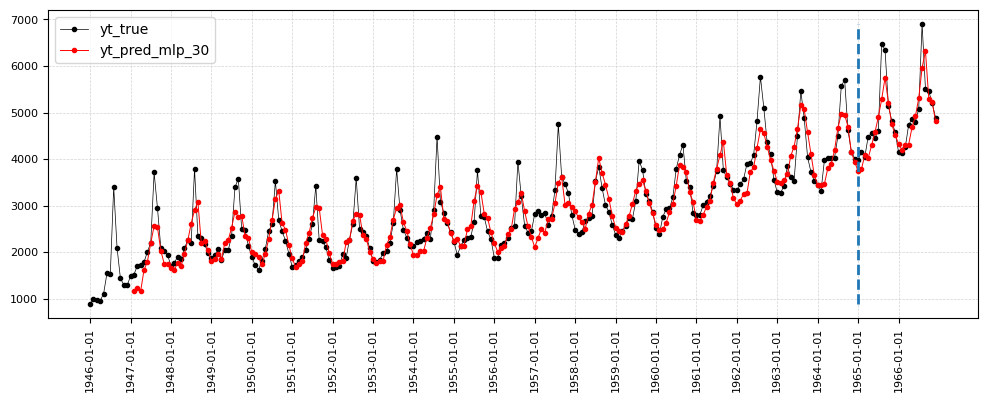

In [8]:
#
# Gráfica de los pronósticos
#
df_orig.loc[df_dropna.index, f"yt_pred_mlp_{hidden}"] = df_dropna[
    f"yt_pred_mlp_{hidden}"
]

functions.plot_time_series(df=df_orig, yt_col="yt_true")

In [9]:
#
# Almacenamiento de los resultados
#
functions.save_forecasts(df_orig)

In [10]:
#
# Métricas de error
#
metrics = functions.compute_evaluation_metrics(df_orig.dropna())
functions.save_metrics(metrics)
metrics

,Metrics,yt_pred_mlp_30
0,MSE Train,114357.70
1,MSE Test,177747.08
2,MAE Train,243.82
3,MAE Test,292.57
